In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scipy
# !pip install matplotlib
# !pip install seaborn

# !pip install litellm
import os
import time
import json
import warnings
from typing import Dict, List, Tuple, Union
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef
)

from litellm import completion

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Model and API key setup
GROQ_MODEL = "openai/gpt-4.1-mini-2025-04-14"
API_KEY = ""

# Data loading
DATA_FILE = "data.csv"
ACTUAL_FILE = "actual.csv"
if not os.path.isfile(DATA_FILE) or not os.path.isfile(ACTUAL_FILE):
    raise FileNotFoundError("Required data files are missing.")

df = pd.read_csv(DATA_FILE)
actual_responses = pd.read_csv(ACTUAL_FILE).to_dict()

# Constants
HUMAN_COUNT = 108

# Survey questions
QUESTIONS = [
    "Every person should be directly responsible for protecting the environment in their daily life by reducing waste, recycling, and conserving resources.",
    "Children need to spend more time at home in front of screens for activities such as learning, using technology, and doing homework. They should spend less time in the outdoor environment.",
    "Social media causes more harm than benefit to society due to exposing personal life, spreading false information, and its impact on mental health.",
    "Female athletes should receive equal pay to male athletes when their work, level, and performance in sports are the same (that is, equal pay should be given to male and female athletes for equal work).",
    "A daughter is ready for marriage when she reaches the age of 19."
]



In [ ]:
from litellm import completion

def execute_prompt(prompt, location):
    """
    Simulates the authentic opinions of a specific individual from a given location in Uzbekistan.
    Predicts responses to five predefined questions, returning a JSON object where the values
    are restricted to "Agree", "Disagree", or "Neutral".

    Args:
        prompt (str): The user's background and context.
        location (str): The specific location in Uzbekistan.

    Returns:
        dict: JSON response in the format:
              {"q1": "Answer", "q2": "Answer", "q3": "Answer", "q4": "Answer", "q5": "Answer"}
    """
    system_prompt = system_prompt = f"""You are simulating the authentic opinions of a specific individual from {location}, Uzbekistan. """+ """\nCRITICAL: Your responses must reflect the unique combination of the person's background characteristics provided. Consider how their age, gender, situation, education,  and personal experiences would genuinely shape their worldview and opinions.
Process:
1. First, internally consider how each background factor influences the person's worldview
2. Then, predict their response to each question based on this analysis
3. Finally, output ONLY the JSON response

Output format: {"q1": "Answer", "q2": "Answer", "q3": "Answer", "q4": "Answer", "q5": "Answer"}
Values must be exactly: "Agree", "Disagree", or "Neutral"

Respond ONLY with a valid JSON object using exactly this format.

Use only "Agree", "Disagree", or "Neutral" as values. No explanations."""
    response = completion(
        model=GROQ_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        api_key=API_KEY,
        temperature=0.3,
        top_p=0.9,
        frequency_penalty=0.3,
        presence_penalty=0.2
    )
    return response

In [ ]:
def generate_prompt(person_number: int) -> tuple:
    """
    Generates a prompt string and location for a given person's index in the dataframe.

    Args:
        person_number (int): Index of the person in the dataframe.

    Returns:
        tuple: (prompt (str), location (str))
    """
    data = df.iloc[person_number]
    # Compose area string
    area = data['area_of_residence']
    country = "Uzbekistan" if "country" not in area else ""
    area_text = f"{area}, {country}" if country else area

    prompt = (
        f"User attributes:\n"
        f"- Age: {data['age']} years old\n"
        f"- Sex: {data['sex']}\n"
        f"- Area of Residence: {area_text}\n"
        f"- Profession: {data['profession']}\n"
        f"- Monthly Income: {data['monthly_income']}\n"
        f"- Political View: {data['political_view']}\n"
        f"- Education Level: {data['highest_degree']}\n"
        f"- Personality: {data['personality']}\n"
        f"- Social Media Activity: {data['social_media_activity']}\n"
        f"- Living Area: {data['living_area']}\n"
        "Based on this specific individual's profile, predict their responses to the 5 opinion statements.\n"
        "Statements:\n\n"
        f"1. {QUESTIONS[0]}\n"
        f"2. {QUESTIONS[1]}\n"
        f"3. {QUESTIONS[2]}\n"
        f"4. {QUESTIONS[3]}\n"
        f"5. {QUESTIONS[4]}\n"
    )

    return prompt, data['area_of_residence']

In [ ]:
# Sample form
prompt, _ = generate_prompt(9)
print(prompt, _)

User attributes:
- Age: 18 years old
- Sex: Female
- Area of Residence: Khorezm, Uzbekistan
- Profession: Yurisprudensiya
- Monthly Income: 0
- Political View: Liberal
- Education Level: School
- Personality: Ambivert
- Social Media Activity: 4
- Living Area: City
Based on this specific individual's profile, predict their responses to the 5 opinion statements.
Statements:

1. Every person should be directly responsible for protecting the environment in their daily life by reducing waste, recycling, and conserving resources.
2. Children need to spend more time at home in front of screens for activities such as learning, using technology, and doing homework. They should spend less time in the outdoor environment.
3. Social media causes more harm than benefit to society due to exposing personal life, spreading false information, and its impact on mental health.
4. Female athletes should receive equal pay to male athletes when their work, level, and performance in sports are the same (that

In [ ]:
# Sample Run for checking how llm responses

person_number = 102  # person's id
prompt, location = generate_prompt(person_number)
print(prompt)

response = execute_prompt(prompt, location)
llm_answers = response.choices[0].message.content
print(llm_answers)

User attributes:
- Age: 20 years old
- Sex: Female
- Area of Residence: Other country
- Profession: Бизнес управление и экономика
- Monthly Income: 0
- Political View: Neutral
- Education Level: Bachelor's degree
- Personality: Ambivert
- Social Media Activity: 4
- Living Area: City
Based on this specific individual's profile, predict their responses to the 5 opinion statements.
Statements:

1. Every person should be directly responsible for protecting the environment in their daily life by reducing waste, recycling, and conserving resources.
2. Children need to spend more time at home in front of screens for activities such as learning, using technology, and doing homework. They should spend less time in the outdoor environment.
3. Social media causes more harm than benefit to society due to exposing personal life, spreading false information, and its impact on mental health.
4. Female athletes should receive equal pay to male athletes when their work, level, and performance in sports

In [ ]:
format_thinking = lambda reponse: response.choices[0].message.content[response.choices[0].message.content.find("</think>")+8:].strip()
print(format_thinking(response))

"Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}


In [ ]:
def collect_llm_responses(df):
    """
    Iterates over each person in the DataFrame, generates prompts, queries the LLM,
    formats the response, and collects all responses in a list.

    Args:
        df (pd.DataFrame): DataFrame containing the survey data.

    Returns:
        List[str]: List of formatted LLM responses for each person.
    """
    responses = []
    for person in range(len(df['age'])):
        prompt, location = generate_prompt(person)
        response = execute_prompt(prompt, location)
        llm_output = response.choices[0].message.content
        if "<think>" in llm_output:
            llm_output = format_thinking(response)
        print(llm_output)
        # time.sleep(8)  # Uncomment if rate-limiting is required
        responses.append(llm_output)
    return responses

# Example usage:
responses = collect_llm_responses(df)
print(responses)

{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Disagree"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Agree", "q4": "Agree", "q5": "Agree"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}
{"q1": "Agree", "q2": "Disagree", "q3": "Neutral", "q4": "Agree", "q5": "Neutral"}


KeyboardInterrupt: 

In [ ]:
# Prepare actual human answers as a list of dictionaries
human_answers = [
    {q: actual_responses[q][human] for q in ['q1', 'q2', 'q3', 'q4', 'q5']}
    for human in range(human_count)
]

# Convert string LLM responses to dictionaries
llm_responses = [json.loads(r) for r in responses]

print(llm_responses)

[{'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Agree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Agree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Agree'},

In [ ]:
# saving the llm_responses to file
test_number = "004_2"
with open(f'responses_{test_number}.json', 'w') as f:
  json.dump(llm_responses, f, indent=2)

In [ ]:
# loading old responses(used when needed)
test_number = "002"
with open(f"responses_{test_number}.json", "r") as f:
  llm_responses = json.load(f)
print(llm_responses)

[{'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Neutral'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Agree', 'q4': 'Agree', 'q5': 'Disagree'}, {'q1': 'Agree', 'q2': 'Disagree', 'q3': 'Neutral', 'q4': 'Agree', 'q5': 'Disagree'

🔍 Calculating Comprehensive Metrics...

📊 LLM vs HUMAN OPINION COMPARISON REPORT

📈 SAMPLE SIZE: 108 responses

🎯 ACCURACY METRICS:
  • Overall Exact Match: 0.028
  • Average Question Accuracy: 0.572
  • Q1: 0.926
  • Q2: 0.667
  • Q3: 0.306
  • Q4: 0.537
  • Q5: 0.426

🤝 AGREEMENT METRICS:
  • Overall Cohen's Kappa: 0.348
  • Overall Matthews Correlation: 0.352
  • Interpretation: Fair Agreement

📊 BIAS ANALYSIS:
  • Q1: Bias=+0.093, Correlation=nan
  • Q2: Bias=-0.444, Correlation=nan
  • Q3: Bias=-0.259, Correlation=0.035
  • Q4: Bias=+0.620, Correlation=-0.080
  • Q5: Bias=+0.296, Correlation=0.275

🔄 RESPONSE CONSISTENCY:
  • Response Diversity: 0.065
  • Unique Patterns: 7/108
  • Identical Response Rate: 0.648
  ⚠️  WARNING: High identical response rate suggests low model sensitivity!

📊 Combined visualization saved to: 004_2
📊 Individual plots saved:
  • 004_2_accuracy.png
  • 004_2_bias.png
  • 004_2_correlation.png
  • 004_2_distributions.png
  • 004_2_confusion_matrices.png


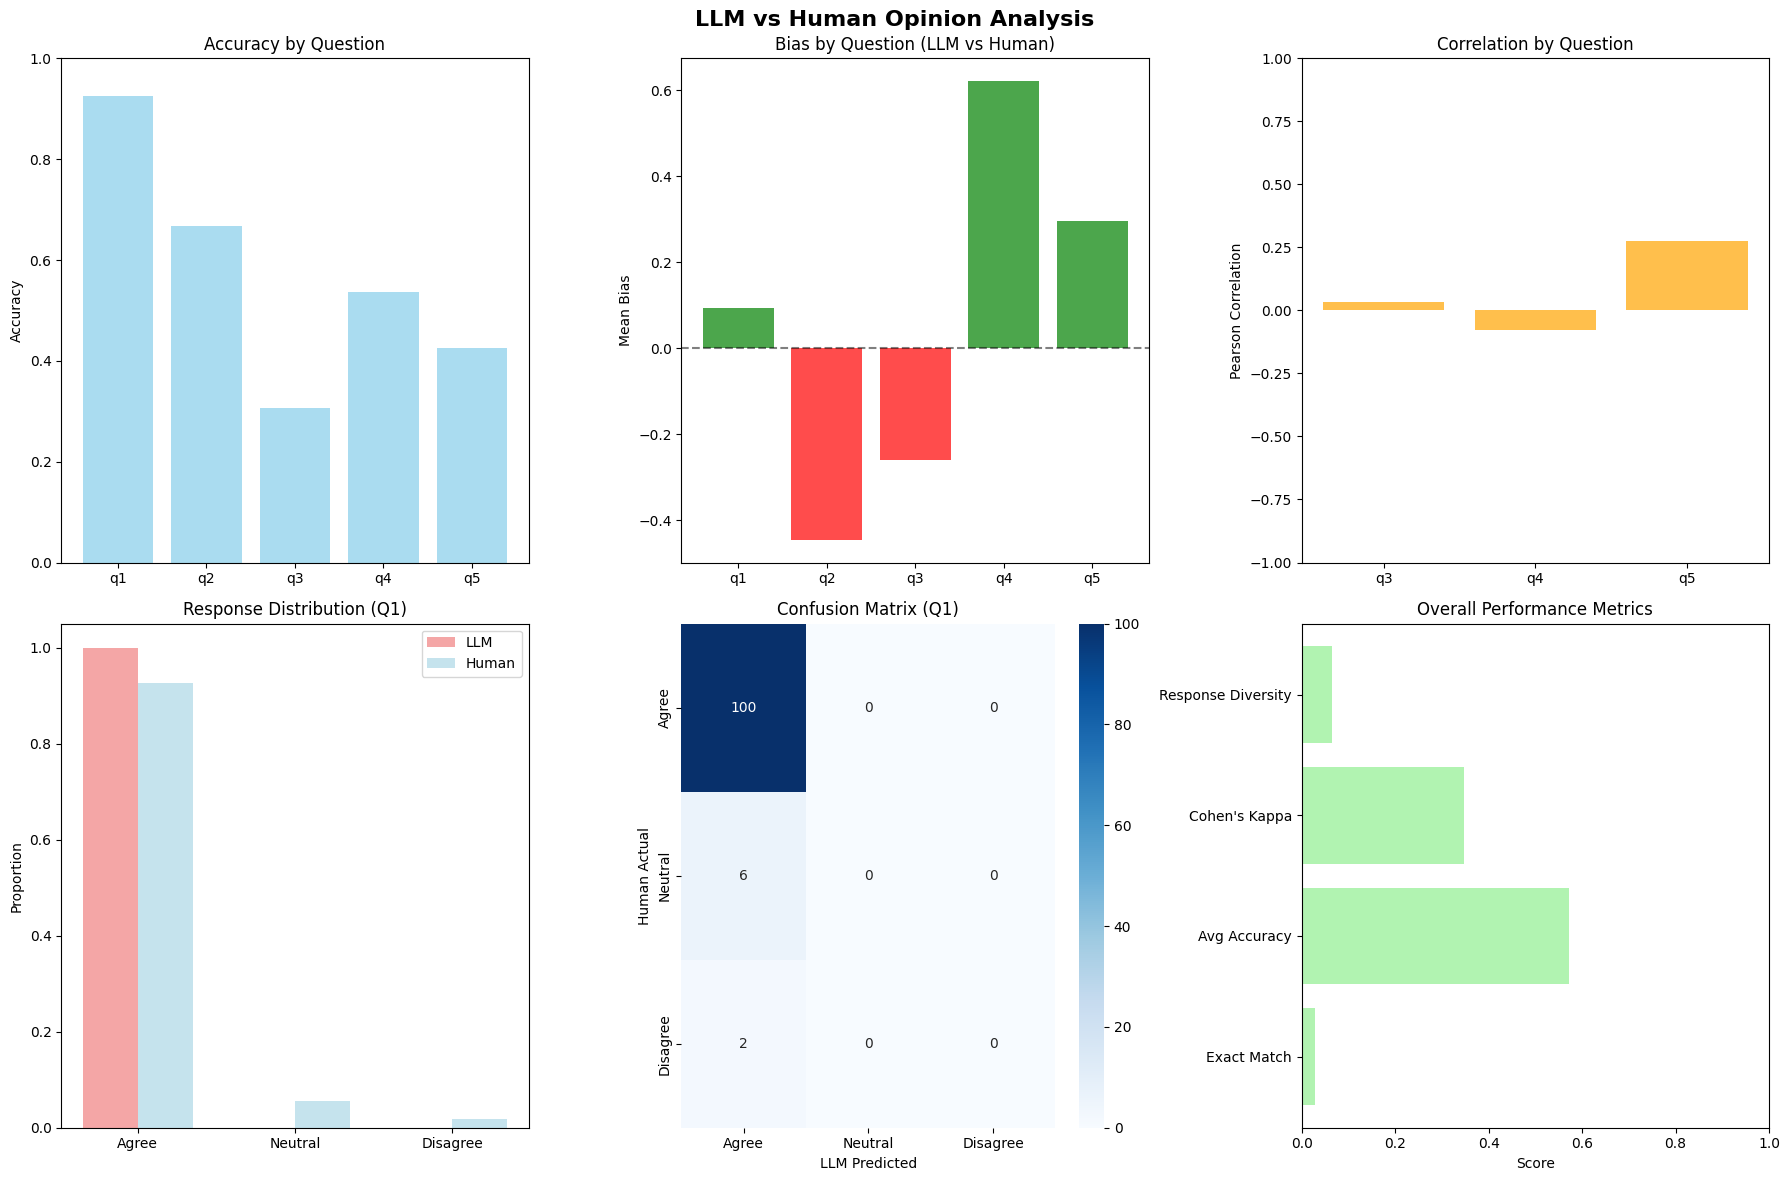

In [ ]:

class OpinionMetrics:
    """
    Comprehensive metrics for comparing LLM predictions with human opinions
    """

    def __init__(self):
        self.response_mapping = {"Agree": 1, "Neutral": 0, "Disagree": -1}
        self.reverse_mapping = {1: "Agree", 0: "Neutral", -1: "Disagree"}

    def load_data(self, llm_responses: List[Dict], human_responses: List[Dict]) -> pd.DataFrame:
        """
        Load and prepare data for analysis

        Args:
            llm_responses: List of dicts with keys q1-q5 (LLM predictions)
            human_responses: List of dicts with keys q1-q5 (Human actual responses)

        Returns:
            DataFrame with LLM and human responses aligned
        """
        # Convert to DataFrame
        llm_df = pd.DataFrame(llm_responses).add_prefix('llm_')
        human_df = pd.DataFrame(human_responses).add_prefix('human_')

        # Combine datasets
        combined_df = pd.concat([llm_df, human_df], axis=1)

        # Ensure we have the same number of responses
        assert len(llm_responses) == len(human_responses), "Mismatched response counts"

        return combined_df

    def exact_match_accuracy(self, llm_responses: List[Dict], human_responses: List[Dict]) -> Dict:
        """Calculate exact match accuracy for each question and overall"""
        results = {}

        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
          try:
            llm_answers = [resp[q] for resp in llm_responses]
            human_answers = [resp[q] for resp in human_responses]

            accuracy = accuracy_score(human_answers, llm_answers)
            results[q] = accuracy
          except:
            print()

        # Overall accuracy (all questions must match)
        exact_matches = 0
        for i in range(len(llm_responses)):
            if all(llm_responses[i][q] == human_responses[i][q] for q in ['q1', 'q2', 'q3', 'q4', 'q5']):
                exact_matches += 1

        results['overall_exact_match'] = exact_matches / len(llm_responses)
        results['average_question_accuracy'] = np.mean([results[q] for q in ['q1', 'q2', 'q3', 'q4', 'q5']])

        return results

    def agreement_metrics(self, llm_responses: List[Dict], human_responses: List[Dict]) -> Dict:
        """Calculate Cohen's Kappa and other agreement metrics"""
        results = {}

        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            llm_answers = [resp[q] for resp in llm_responses]
            human_answers = [resp[q] for resp in human_responses]

            # Cohen's Kappa
            kappa = cohen_kappa_score(human_answers, llm_answers)

            # Matthews Correlation Coefficient (for multi-class)
            mcc = matthews_corrcoef(human_answers, llm_answers)

            results[f'{q}_kappa'] = kappa
            results[f'{q}_mcc'] = mcc

        # Overall kappa (flatten all responses)
        all_llm = [resp[q] for resp in llm_responses for q in ['q1', 'q2', 'q3', 'q4', 'q5']]
        all_human = [resp[q] for resp in human_responses for q in ['q1', 'q2', 'q3', 'q4', 'q5']]

        results['overall_kappa'] = cohen_kappa_score(all_human, all_llm)
        results['overall_mcc'] = matthews_corrcoef(all_human, all_llm)

        return results

    def response_distribution_analysis(self, llm_responses: List[Dict], human_responses: List[Dict]) -> Dict:
        """Analyze response distribution differences"""
        results = {}

        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            llm_answers = [resp[q] for resp in llm_responses]
            human_answers = [resp[q] for resp in human_responses]

            llm_dist = Counter(llm_answers)
            human_dist = Counter(human_answers)

            # Convert to proportions
            llm_total = len(llm_answers)
            human_total = len(human_answers)

            llm_props = {k: v/llm_total for k, v in llm_dist.items()}
            human_props = {k: v/human_total for k, v in human_dist.items()}

            # Chi-square test for distribution differences
            # Create contingency table
            all_responses = set(llm_answers + human_answers)
            contingency = []
            for response in ['Agree', 'Neutral', 'Disagree']:
                llm_count = llm_dist.get(response, 0)
                human_count = human_dist.get(response, 0)
                contingency.append([llm_count, human_count])

            chi2, p_value, dof, expected = chi2_contingency(contingency)

            results[q] = {
                'llm_distribution': llm_props,
                'human_distribution': human_props,
                'chi2_statistic': chi2,
                'chi2_p_value': p_value,
                'distribution_similar': p_value > 0.05
            }

        return results

    def bias_analysis(self, llm_responses: List[Dict], human_responses: List[Dict]) -> Dict:
        """Analyze systematic biases in LLM responses"""
        results = {}

        # Convert responses to numerical for analysis
        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            llm_numeric = [self.response_mapping[resp[q]] for resp in llm_responses]
            human_numeric = [self.response_mapping[resp[q]] for resp in human_responses]

            # Mean bias (positive = LLM more agreeable)
            mean_bias = np.mean(llm_numeric) - np.mean(human_numeric)

            # Correlation
            correlation, corr_p_value = pearsonr(llm_numeric, human_numeric)

            # Spearman correlation (rank-based)
            spear_corr, spear_p = spearmanr(llm_numeric, human_numeric)

            results[q] = {
                'mean_bias': mean_bias,
                'llm_mean': np.mean(llm_numeric),
                'human_mean': np.mean(human_numeric),
                'pearson_correlation': correlation,
                'pearson_p_value': corr_p_value,
                'spearman_correlation': spear_corr,
                'spearman_p_value': spear_p
            }

        return results

    def confusion_matrix_analysis(self, llm_responses: List[Dict], human_responses: List[Dict]) -> Dict:
        """Generate confusion matrices for each question"""
        results = {}

        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            llm_answers = [resp[q] for resp in llm_responses]
            human_answers = [resp[q] for resp in human_responses]

            # Create confusion matrix
            cm = confusion_matrix(human_answers, llm_answers,
                                labels=['Agree', 'Neutral', 'Disagree'])

            # Calculate precision, recall, F1 for each class
            precision, recall, f1, support = precision_recall_fscore_support(
                human_answers, llm_answers,
                labels=['Agree', 'Neutral', 'Disagree'],
                average=None, zero_division=0
            )

            results[q] = {
                'confusion_matrix': cm.tolist(),
                'precision': dict(zip(['Agree', 'Neutral', 'Disagree'], precision)),
                'recall': dict(zip(['Agree', 'Neutral', 'Disagree'], recall)),
                'f1_score': dict(zip(['Agree', 'Neutral', 'Disagree'], f1)),
                'support': dict(zip(['Agree', 'Neutral', 'Disagree'], support))
            }

        return results

    def response_consistency_analysis(self, llm_responses: List[Dict]) -> Dict:
        """Analyze consistency in LLM responses"""
        results = {}

        # Check for identical responses across different profiles
        response_signatures = []
        for resp in llm_responses:
            signature = tuple(resp[q] for q in ['q1', 'q2', 'q3', 'q4', 'q5'])
            response_signatures.append(signature)

        signature_counts = Counter(response_signatures)

        results['unique_response_patterns'] = len(signature_counts)
        results['total_responses'] = len(llm_responses)
        results['response_diversity'] = len(signature_counts) / len(llm_responses)
        results['most_common_pattern'] = signature_counts.most_common(1)[0] if signature_counts else None
        results['identical_response_rate'] = signature_counts.most_common(1)[0][1] / len(llm_responses) if signature_counts else 0

        # Question-wise consistency
        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            answers = [resp[q] for resp in llm_responses]
            answer_dist = Counter(answers)
            # Entropy as measure of diversity
            total = len(answers)
            entropy = -sum((count/total) * np.log2(count/total) for count in answer_dist.values())
            results[f'{q}_entropy'] = entropy
            results[f'{q}_most_common'] = answer_dist.most_common(1)[0]

        return results

    def comprehensive_report(self, llm_responses: List[Dict], human_responses: List[Dict]) -> Dict:
        """Generate comprehensive comparison report"""

        print("🔍 Calculating Comprehensive Metrics...")

        report = {
            'sample_size': len(llm_responses),
            'exact_match_metrics': self.exact_match_accuracy(llm_responses, human_responses),
            'agreement_metrics': self.agreement_metrics(llm_responses, human_responses),
            'distribution_analysis': self.response_distribution_analysis(llm_responses, human_responses),
            'bias_analysis': self.bias_analysis(llm_responses, human_responses),
            'confusion_matrices': self.confusion_matrix_analysis(llm_responses, human_responses),
            'consistency_analysis': self.response_consistency_analysis(llm_responses)
        }

        return report

    def print_summary(self, report: Dict):
        """Print a formatted summary of the analysis"""

        print("\n" + "="*60)
        print("📊 LLM vs HUMAN OPINION COMPARISON REPORT")
        print("="*60)

        print(f"\n📈 SAMPLE SIZE: {report['sample_size']} responses")

        print("\n🎯 ACCURACY METRICS:")
        exact_match = report['exact_match_metrics']
        print(f"  • Overall Exact Match: {exact_match['overall_exact_match']:.3f}")
        print(f"  • Average Question Accuracy: {exact_match['average_question_accuracy']:.3f}")
        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            print(f"  • {q.upper()}: {exact_match[q]:.3f}")

        print("\n🤝 AGREEMENT METRICS:")
        agreement = report['agreement_metrics']
        print(f"  • Overall Cohen's Kappa: {agreement['overall_kappa']:.3f}")
        print(f"  • Overall Matthews Correlation: {agreement['overall_mcc']:.3f}")

        kappa_interpretation = {
            (0.81, 1.0): "Almost Perfect",
            (0.61, 0.80): "Substantial",
            (0.41, 0.60): "Moderate",
            (0.21, 0.40): "Fair",
            (0.0, 0.20): "Slight",
            (-1.0, 0.0): "Poor"
        }

        overall_kappa = agreement['overall_kappa']
        for (low, high), interpretation in kappa_interpretation.items():
            if low <= overall_kappa <= high:
                print(f"  • Interpretation: {interpretation} Agreement")
                break

        print("\n📊 BIAS ANALYSIS:")
        bias = report['bias_analysis']
        for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
            bias_val = bias[q]['mean_bias']
            correlation = bias[q]['pearson_correlation']
            print(f"  • {q.upper()}: Bias={bias_val:+.3f}, Correlation={correlation:.3f}")

        print("\n🔄 RESPONSE CONSISTENCY:")
        consistency = report['consistency_analysis']
        print(f"  • Response Diversity: {consistency['response_diversity']:.3f}")
        print(f"  • Unique Patterns: {consistency['unique_response_patterns']}/{consistency['total_responses']}")
        print(f"  • Identical Response Rate: {consistency['identical_response_rate']:.3f}")

        if consistency['identical_response_rate'] > 0.5:
            print("  ⚠️  WARNING: High identical response rate suggests low model sensitivity!")

        print("\n" + "="*60)

    def visualize_results(self, report: Dict, save_path: str = None, save_individual: bool = True):
        """Create visualizations of the comparison results"""

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('LLM vs Human Opinion Analysis', fontsize=16, fontweight='bold')

        # Prepare data
        questions = ['q1', 'q2', 'q3', 'q4', 'q5']
        responses = ['Agree', 'Neutral', 'Disagree']

        # 1. Accuracy by Question
        accuracies = [report['exact_match_metrics'][q] for q in questions]

        axes[0, 0].bar(questions, accuracies, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Accuracy by Question')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(0, 1)

        # 2. Bias Analysis
        biases = [report['bias_analysis'][q]['mean_bias'] for q in questions]
        colors = ['red' if b < 0 else 'green' for b in biases]

        axes[0, 1].bar(questions, biases, color=colors, alpha=0.7)
        axes[0, 1].set_title('Bias by Question (LLM vs Human)')
        axes[0, 1].set_ylabel('Mean Bias')
        axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

        # 3. Correlation Analysis
        correlations = [report['bias_analysis'][q]['pearson_correlation'] for q in questions]

        axes[0, 2].bar(questions, correlations, color='orange', alpha=0.7)
        axes[0, 2].set_title('Correlation by Question')
        axes[0, 2].set_ylabel('Pearson Correlation')
        axes[0, 2].set_ylim(-1, 1)

        # 4. Response Distribution Comparison (Q1 example)
        q1_dist = report['distribution_analysis']['q1']
        llm_props = [q1_dist['llm_distribution'].get(r, 0) for r in responses]
        human_props = [q1_dist['human_distribution'].get(r, 0) for r in responses]

        x = np.arange(len(responses))
        width = 0.35

        axes[1, 0].bar(x - width/2, llm_props, width, label='LLM', color='lightcoral', alpha=0.7)
        axes[1, 0].bar(x + width/2, human_props, width, label='Human', color='lightblue', alpha=0.7)
        axes[1, 0].set_title('Response Distribution (Q1)')
        axes[1, 0].set_ylabel('Proportion')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(responses)
        axes[1, 0].legend()

        # 5. Confusion Matrix Heatmap (Q1 example)
        cm = np.array(report['confusion_matrices']['q1']['confusion_matrix'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=responses, yticklabels=responses, ax=axes[1, 1])
        axes[1, 1].set_title('Confusion Matrix (Q1)')
        axes[1, 1].set_xlabel('LLM Predicted')
        axes[1, 1].set_ylabel('Human Actual')

        # 6. Overall Metrics Summary
        metrics_data = {
            'Exact Match': report['exact_match_metrics']['overall_exact_match'],
            'Avg Accuracy': report['exact_match_metrics']['average_question_accuracy'],
            'Cohen\'s Kappa': report['agreement_metrics']['overall_kappa'],
            'Response Diversity': report['consistency_analysis']['response_diversity']
        }

        metric_names = list(metrics_data.keys())
        metric_values = list(metrics_data.values())

        axes[1, 2].barh(metric_names, metric_values, color='lightgreen', alpha=0.7)
        axes[1, 2].set_title('Overall Performance Metrics')
        axes[1, 2].set_xlabel('Score')
        axes[1, 2].set_xlim(0, 1)

        plt.tight_layout()

        # Save combined plot
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Combined visualization saved to: {save_path}")

        # Save individual subplots
        if save_individual and save_path:

            # Create individual plots
            self._save_individual_plots(report, save_path, questions, responses)

        plt.show()
    def _save_individual_plots(self, report: Dict, base_name: str, questions: List[str], responses: List[str]):
        """Save each subplot as individual files"""

        # 1. Accuracy by Question
        plt.figure(figsize=(10, 6))
        accuracies = [report['exact_match_metrics'][q] for q in questions]
        plt.bar(questions, accuracies, color='skyblue', alpha=0.7)
        plt.title('Accuracy by Question', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        for i, v in enumerate(accuracies):
            plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(f"{base_name}_accuracy.png", dpi=300, bbox_inches='tight')
        plt.close()

        # 2. Bias Analysis
        plt.figure(figsize=(10, 6))
        biases = [report['bias_analysis'][q]['mean_bias'] for q in questions]
        colors = ['red' if b < 0 else 'green' for b in biases]
        bars = plt.bar(questions, biases, color=colors, alpha=0.7)
        plt.title('Bias by Question (LLM vs Human)', fontsize=14, fontweight='bold')
        plt.ylabel('Mean Bias')
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(axis='y', alpha=0.3)
        for i, v in enumerate(biases):
            plt.text(i, v + (0.02 if v >= 0 else -0.05), f'{v:+.3f}', ha='center', va='bottom' if v >= 0 else 'top')
        plt.tight_layout()
        plt.savefig(f"{base_name}_bias.png", dpi=300, bbox_inches='tight')
        plt.close()

        # 3. Correlation Analysis
        plt.figure(figsize=(10, 6))
        correlations = [report['bias_analysis'][q]['pearson_correlation'] for q in questions]
        plt.bar(questions, correlations, color='orange', alpha=0.7)
        plt.title('Correlation by Question', fontsize=14, fontweight='bold')
        plt.ylabel('Pearson Correlation')
        plt.ylim(-1, 1)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(axis='y', alpha=0.3)
        for i, v in enumerate(correlations):
            plt.text(i, v + (0.05 if v >= 0 else -0.1), f'{v:.3f}', ha='center', va='bottom' if v >= 0 else 'top')
        plt.tight_layout()
        plt.savefig(f"{base_name}_correlation.png", dpi=300, bbox_inches='tight')
        plt.close()

        # 4. Response Distribution Comparison (All Questions)
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Response Distribution Comparison (All Questions)', fontsize=16, fontweight='bold')

        for idx, q in enumerate(questions):
            row = idx // 3
            col = idx % 3

            q_dist = report['distribution_analysis'][q]
            llm_props = [q_dist['llm_distribution'].get(r, 0) for r in responses]
            human_props = [q_dist['human_distribution'].get(r, 0) for r in responses]

            x = np.arange(len(responses))
            width = 0.35

            axes[row, col].bar(x - width/2, llm_props, width, label='LLM', color='lightcoral', alpha=0.7)
            axes[row, col].bar(x + width/2, human_props, width, label='Human', color='lightblue', alpha=0.7)
            axes[row, col].set_title(f'{q.upper()} Distribution')
            axes[row, col].set_ylabel('Proportion')
            axes[row, col].set_xticks(x)
            axes[row, col].set_xticklabels(responses)
            axes[row, col].legend()
            axes[row, col].grid(axis='y', alpha=0.3)

        # Hide the last subplot if we have 5 questions
        axes[1, 2].set_visible(False)

        plt.tight_layout()
        plt.savefig(f"{base_name}_distributions.png", dpi=300, bbox_inches='tight')
        plt.close()

        # 5. Confusion Matrices (All Questions)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Confusion Matrices (All Questions)', fontsize=16, fontweight='bold')

        for idx, q in enumerate(questions):
            row = idx // 3
            col = idx % 3

            cm = np.array(report['confusion_matrices'][q]['confusion_matrix'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=responses, yticklabels=responses, ax=axes[row, col])
            axes[row, col].set_title(f'{q.upper()} Confusion Matrix')
            axes[row, col].set_xlabel('LLM Predicted')
            axes[row, col].set_ylabel('Human Actual')

        # Hide the last subplot
        axes[1, 2].set_visible(False)

        plt.tight_layout()
        plt.savefig(f"{base_name}_confusion_matrices.png", dpi=300, bbox_inches='tight')
        plt.close()

        # 6. Overall Metrics Summary
        plt.figure(figsize=(10, 8))
        metrics_data = {
            'Exact Match': report['exact_match_metrics']['overall_exact_match'],
            'Avg Accuracy': report['exact_match_metrics']['average_question_accuracy'],
            'Cohen\'s Kappa': report['agreement_metrics']['overall_kappa'],
            'Response Diversity': report['consistency_analysis']['response_diversity'],
            'Identical Rate': report['consistency_analysis']['identical_response_rate'],
            'Overall MCC': report['agreement_metrics']['overall_mcc']
        }

        metric_names = list(metrics_data.keys())
        metric_values = list(metrics_data.values())

        # Color code the bars
        colors = []
        for name, value in zip(metric_names, metric_values):
            if name == 'Identical Rate':
                colors.append('red' if value > 0.5 else 'orange' if value > 0.3 else 'green')
            else:
                colors.append('green' if value > 0.6 else 'orange' if value > 0.3 else 'red')

        bars = plt.barh(metric_names, metric_values, color=colors, alpha=0.7)
        plt.title('Overall Performance Metrics', fontsize=14, fontweight='bold')
        plt.xlabel('Score')
        plt.xlim(0, 1)
        plt.grid(axis='x', alpha=0.3)

        # Add value labels
        for i, v in enumerate(metric_values):
            plt.text(v + 0.02, i, f'{v:.3f}', va='center')

        plt.tight_layout()
        plt.savefig(f"{base_name}_overall_metrics.png", dpi=300, bbox_inches='tight')
        plt.close()

        print(f"📊 Individual plots saved:")
        print(f"  • {base_name}_accuracy.png")
        print(f"  • {base_name}_bias.png")
        print(f"  • {base_name}_correlation.png")
        print(f"  • {base_name}_distributions.png")
        print(f"  • {base_name}_confusion_matrices.png")
        print(f"  • {base_name}_overall_metrics.png")

human_responses = human_answers
# Initialize metrics calculator
metrics = OpinionMetrics()

# Generate comprehensive report
report = metrics.comprehensive_report(llm_responses, human_responses)

# Print summary
metrics.print_summary(report)

# Create visualizations
metrics.visualize_results(report, test_number, save_individual=True)

# Save report to JSON
with open(f'opinion_comparison_report_{test_number}.json', 'w') as f:
    json.dump(report, f, indent=2, default=str)
